In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
os.makedirs('plots', exist_ok=True)

In [2]:
#df = pd.read_csv('crossvalidation_bert_03102020.csv', na_values=' nan')
df = pd.read_csv('crossval_results_w_signalp.csv')

In [3]:
df['crossval_mean'] = df[df.columns[6:26]].mean(axis=1)
df['crossval_std'] = df[df.columns[6:26]].std(axis=1)

### MCC

In [4]:
plotname_dict = {'SP': 'Sec/SPI', 'LIPO':'Sec/SPII', 'TAT':'Tat/SPI'}
df['type'] = df['type'].apply(lambda x: plotname_dict[x])

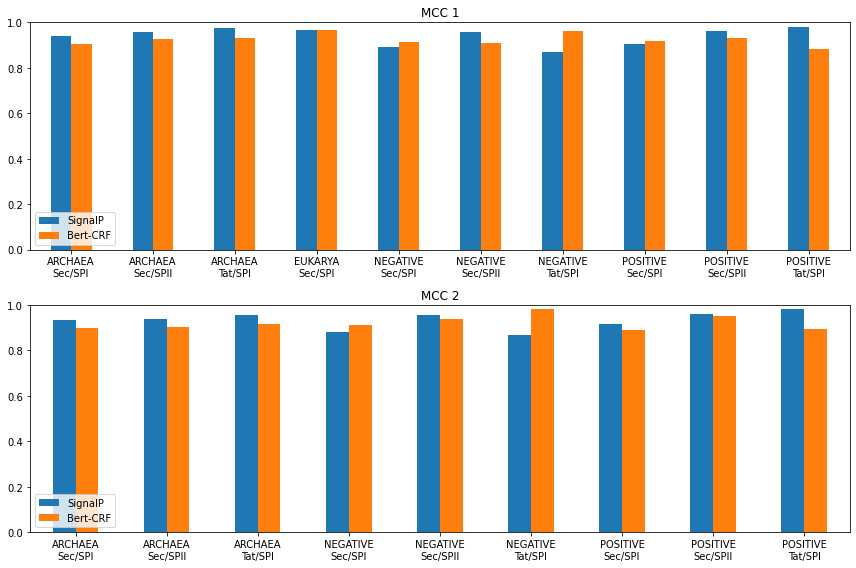

In [5]:
plt.figure(figsize = (12,8))

ax= plt.subplot(2,1,1)

df_plot = df.loc[df['metric'] == 'mcc1'][['kingdom', 'type','SignalP', 'crossval_mean']]#, 'crossval_std']]
df_plot = df_plot.set_index(df_plot['kingdom'] + '\n' + df_plot['type'])

df_plot = df_plot.rename({'crossval_mean': 'Bert-CRF'}, axis =1)

df_plot.plot(kind='bar', ax=ax, ylim =(0,1), rot=0).legend(loc='lower left')
plt.title('MCC 1')

ax=plt.subplot(2,1,2)
df_plot = df.loc[df['kingdom'].isin(['ARCHAEA','POSITIVE', 'NEGATIVE'])]
df_plot = df_plot.loc[df['metric'] == 'mcc2'][['kingdom', 'type','SignalP', 'crossval_mean']]#, 'crossval_std']]
df_plot = df_plot.set_index(df_plot['kingdom'] + '\n' + df_plot['type'])

df_plot = df_plot.rename({'crossval_mean': 'Bert-CRF'}, axis =1)

df_plot.plot(kind='bar', ax=ax, ylim =(0,1), rot=0).legend(loc='lower left')
plt.title('MCC 2')

plt.tight_layout()
plt.savefig('plots/mcc_crossval_bert.png')

### CS Recall

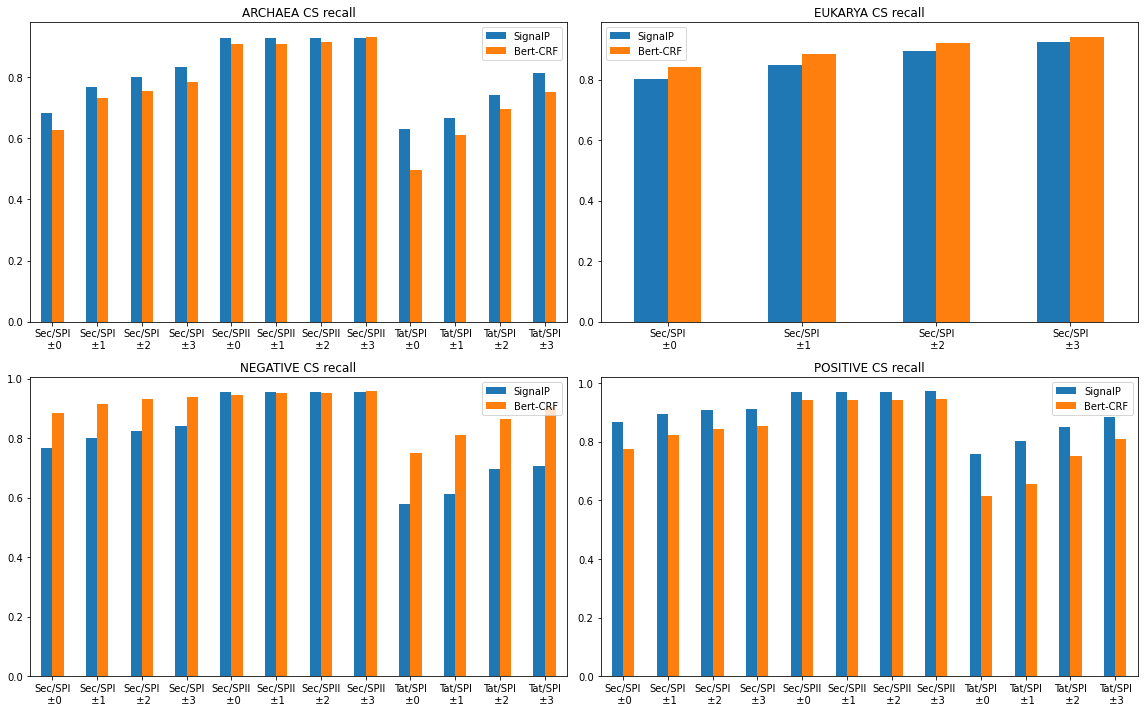

In [6]:
df_plot = df.loc[df['metric'] == 'recall'][['kingdom', 'type', 'window', 'SignalP', 'crossval_mean']]#, 'crossval_std']]
df_plot = df_plot.set_index(df_plot['type'] + '\n ±' + df_plot['window'].astype(int).astype(str))

df_plot = df_plot.rename({'crossval_mean': 'Bert-CRF'}, axis =1)

plt.figure(figsize=(16,10))
for idx, kingdom in enumerate(df_plot['kingdom'].unique()):
    ax = plt.subplot(2,2,idx+1)
    df_plot.loc[df_plot['kingdom'] == kingdom][['SignalP', 'Bert-CRF']].plot(kind='bar', ax = ax, title= kingdom + ' CS recall', rot=0)

plt.tight_layout()
#df_plot[['SignalP', 'Bert-CRF']].plot(kind='bar')
plt.savefig('plots/recall_crossval_bert.png')

### CS Precision

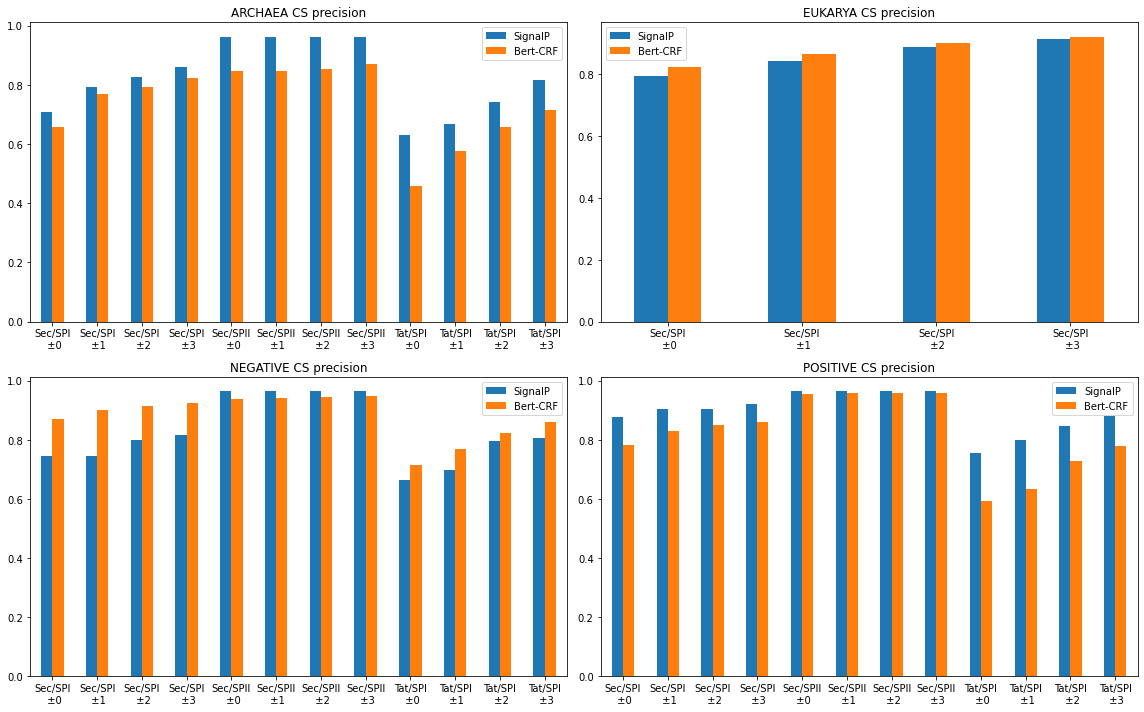

In [7]:
df_plot = df.loc[df['metric'] == 'precision'][['kingdom', 'type', 'window', 'SignalP', 'crossval_mean']]#, 'crossval_std']]
df_plot = df_plot.set_index(df_plot['type'] + ' ' + df_plot['window'].astype(int).astype(str))
df_plot = df_plot.set_index(df_plot['type'] + '\n ±' + df_plot['window'].astype(int).astype(str))

df_plot = df_plot.rename({'crossval_mean': 'Bert-CRF'}, axis =1)

plt.figure(figsize=(16,10))
for idx, kingdom in enumerate(df_plot['kingdom'].unique()):
    ax = plt.subplot(2,2,idx+1)
    df_plot.loc[df_plot['kingdom'] == kingdom][['SignalP', 'Bert-CRF']].plot(kind='bar', ax = ax, title= kingdom + ' CS precision', rot=0)

plt.tight_layout()
#df_plot[['SignalP', 'Bert-CRF']].plot(kind='bar')
plt.savefig('plots/precision_crossval_bert.png')

## Look at individual predictions - done wrong
Here I averaged over all predictions, not just the ones that had the split as their test set. Wrong way to do a crossvalidated confusion matrix.

In [119]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
df = pd.read_csv('../investigate_model/complete_set_probs_loss.csv')

In [120]:
#get preds
df['prediction'] = df[['p_NO', 'p_SPI', 'p_SPII','p_TAT']].idxmax(axis=1)

In [121]:
labelidx = {'p_NO': 0, 'p_SPI': 1, 'p_SPII': 2, 'p_TAT':3}
df['prediction'] = df['prediction'].apply(lambda x: labelidx[x])

In [122]:
confusion =confusion_matrix(df['target'].astype(int), df['prediction'])

In [11]:
def make_conf_matrix(y_true, y_pred, percent=False):
    confusion = confusion_matrix(y_true, y_pred)
    categories = ['NO SP', 'SP I', 'SP II','TAT']
    if percent:
        confusion_norm = confusion/confusion.sum(axis=1)[:, None]
        
        group_counts = ['{0:0.0f}'.format(value) for value in confusion.flatten()]
        group_percentages = ['{0:.1%}'.format(value) for value in confusion_norm.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(len(categories),len(categories))
        
        sns.heatmap(confusion_norm, cmap="Blues", annot=labels, xticklabels=categories,yticklabels=categories, fmt='', cbar=False)

    else:
        sns.heatmap(confusion, cmap="Blues", annot= True, xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

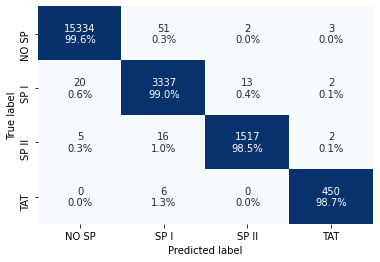

In [124]:
make_conf_matrix(df['target'].astype(int), df['prediction'], percent=True)

/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0.5, 0.98, 'Ensemble predictions (20 models)')

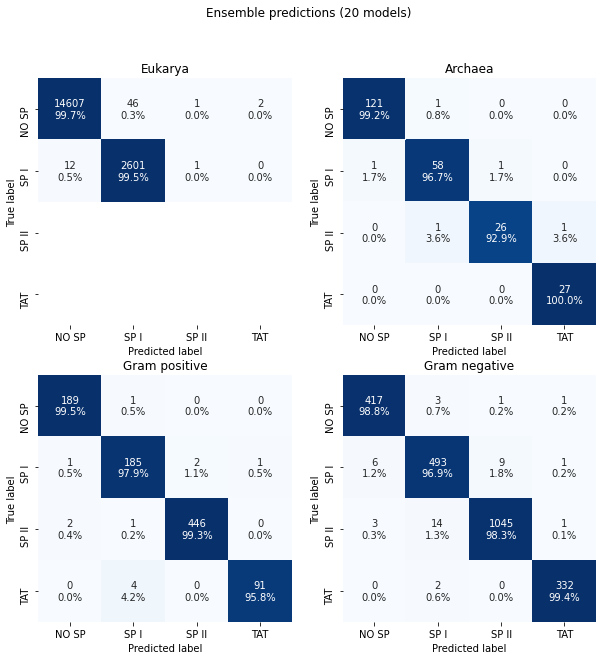

In [127]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title('Eukarya')
df_plot = df.loc[df['Kingdom']=='EUKARYA']
make_conf_matrix(df_plot['target'].astype(int), df_plot['prediction'], percent=True)

plt.subplot(2,2,2)
plt.title('Archaea')
df_plot = df.loc[df['Kingdom']=='ARCHAEA']
make_conf_matrix(df_plot['target'].astype(int), df_plot['prediction'], percent=True)

plt.subplot(2,2,3)
plt.title('Gram positive')
df_plot = df.loc[df['Kingdom']=='POSITIVE']
make_conf_matrix(df_plot['target'].astype(int), df_plot['prediction'], percent=True)

plt.subplot(2,2,4)
plt.title('Gram negative')
df_plot = df.loc[df['Kingdom']=='NEGATIVE']
make_conf_matrix(df_plot['target'].astype(int), df_plot['prediction'], percent=True)

plt.suptitle('Ensemble predictions (20 models)')

## Correct way to get confusion matrices after cross-validation

__Inner loop:__ Mean over outputs  
__Outer loop:__ Only get predictions for the corresponding test mean for each sample, ignore the other outputs

#### Fix eukarya predictions and get test-models prediction for each sequence

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import sys
sys.path.append('..')
from investigate_model.plotting_utils import fix_eukarya_preds
df = pd.read_csv('../investigate_model/all_model_outputs.csv')
df = fix_eukarya_preds(df)

labelidx = {'p_NO': 0, 'p_SPI': 1, 'p_SPII': 2, 'p_TAT':3}


In [11]:
# for each group, get prediction from mean of test set models
df['test_prediction'] = ''
df['test_loss'] = ''
df['test_p_NO'] = ''
df['test_p_SPI'] = ''
df['test_p_SPII'] = ''
df['test_p_TAT'] = ''
df['test_CS'] = ''

for partition in df['Partition'].unique():
    
    #select the subset of the partition
    inner_loop_column_names = [x for x in df.columns if f'T{partition}V' in x]
    inner_df = df[inner_loop_column_names].loc[df['Partition']== partition]
    
    #get mean for each metric
    for metric in ['CS model', 'p_NO model', 'p_SPI model', 'p_SPII model', 'p_TAT model', 'loss model']:
        metric_column_names = [x for x in inner_df.columns if metric in x]    
        inner_df[metric] = inner_df[metric_column_names].mean(axis=1)

    #predict label from mean probs
    pred = inner_df[['p_NO model', 'p_SPI model', 'p_SPII model', 'p_TAT model']].idxmax(axis=1)
    pred = pred.apply(lambda x: labelidx[x.rstrip(' model')])
    
    #set result in original df in respective rows
    df.loc[np.where(df['Partition']==partition)[0],'test_prediction'] = pred
    df.loc[np.where(df['Partition']==partition)[0],'test_loss'] = inner_df['loss model']
    
    df.loc[np.where(df['Partition']==partition)[0],'test_p_NO'] = inner_df['p_NO model']
    df.loc[np.where(df['Partition']==partition)[0],'test_p_SPI'] = inner_df['p_SPI model']
    df.loc[np.where(df['Partition']==partition)[0],'test_p_SPII'] = inner_df['p_SPII model']
    df.loc[np.where(df['Partition']==partition)[0],'test_p_TAT'] = inner_df['p_TAT model']
    df.loc[np.where(df['Partition']==partition)[0],'test_CS'] = inner_df['CS model']

#df.loc[df['Partition']==1]
df['test_p_NO'] = df['test_p_NO'].astype(float)
df['test_p_SPI'] = df['test_p_SPI'].astype(float)
df['test_p_SPII'] = df['test_p_SPII'].astype(float)
df['test_p_TAT'] = df['test_p_TAT'].astype(float)
df['test_prediction'] = df['test_prediction'].astype(int)
df['test_loss'] = df['test_loss'].astype(float)

In [13]:
#['NO SP', 'SP I', 'SP II','TAT']
def make_conf_matrix(y_true, y_pred, percent=False, categories= ['Other', 'Sec\nSPI', 'Sec\nSPII' ,'Tat\nSPI'], label_size = 10, axlabel_size=10, tick_size=10, ax=None):
    confusion = confusion_matrix(y_true, y_pred)
    if percent:
        confusion_norm = confusion/confusion.sum(axis=1)[:, None]
        
        group_counts = ['{0:0.0f}'.format(value) for value in confusion.flatten()]
        group_percentages = ['{0:.1%}'.format(value) for value in confusion_norm.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(len(categories),len(categories))
        
        b= sns.heatmap(confusion_norm, cmap="Blues", annot=labels, xticklabels=categories,yticklabels=categories, fmt='', cbar=False,
                   annot_kws={"size": label_size}, ax=ax)

    else:
        b= sns.heatmap(confusion, cmap="Blues", annot= True, xticklabels=categories,yticklabels=categories)
    
    #resize labels
    #b.set_yticklabels(b.get_yticks(), size = tick_size)
    #b.set_xticklabels(b.get_xticks(), size= tick_size)

    #plt.ylabel('True label', size=axlabel_size)
    #plt.xlabel('Predicted label', size=axlabel_size)
    
    return b

def plot_conf_matrix(confusion, categories = ['Other', 'Sec\nSPI', 'Sec\nSPII' ,'Tat\nSPI'], label_size=10, axlabel_size=10, tick_size=10, ax=None):
    '''For precomputed confusion matrices'''
    confusion_norm = confusion/confusion.sum(axis=1)[:, None]
    group_counts = ['{0:0.0f}'.format(value) for value in confusion.flatten()]
    group_percentages = ['{0:.1%}'.format(value) for value in confusion_norm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(len(categories),len(categories))
    b= sns.heatmap(confusion_norm, cmap="Blues", annot=labels, xticklabels=categories,yticklabels=categories, fmt='', cbar=False,
                annot_kws={"size": label_size}, ax=ax)
    
    #b.set_yticklabels(b.get_yticks(), size = tick_size)
    #b.set_xticklabels(b.get_xticks(), size= tick_size)
    plt.ylabel('True label', size=axlabel_size)
    plt.xlabel('Predicted label', size=axlabel_size)
    
    return b

In [14]:
#data from signalp supplement, same format as here
signalp_euk_matrix = np.array([[13573+995, 39+49],
                      [64, 2550], 
                     ])
signalp_arc_matrix = np.array([[78+43, 1, 0,0],
                      [3,56,1,0],
                      [0,1,26,1],
                      [1,0,0,26]
                     ])
signalp_pos_matrix = np.array([[139+45, 1+5, 0, 0],
                      [7,174,3,5],
                      [8,4,437,0],
                      [1,11,5,78]
                     ])
signalp_neg_matrix = np.array([[201+208, 9,1+1,2],
                      [14,474,18,3],
                      [3,19,1040,1],
                      [0,2,3,329]
                     ])

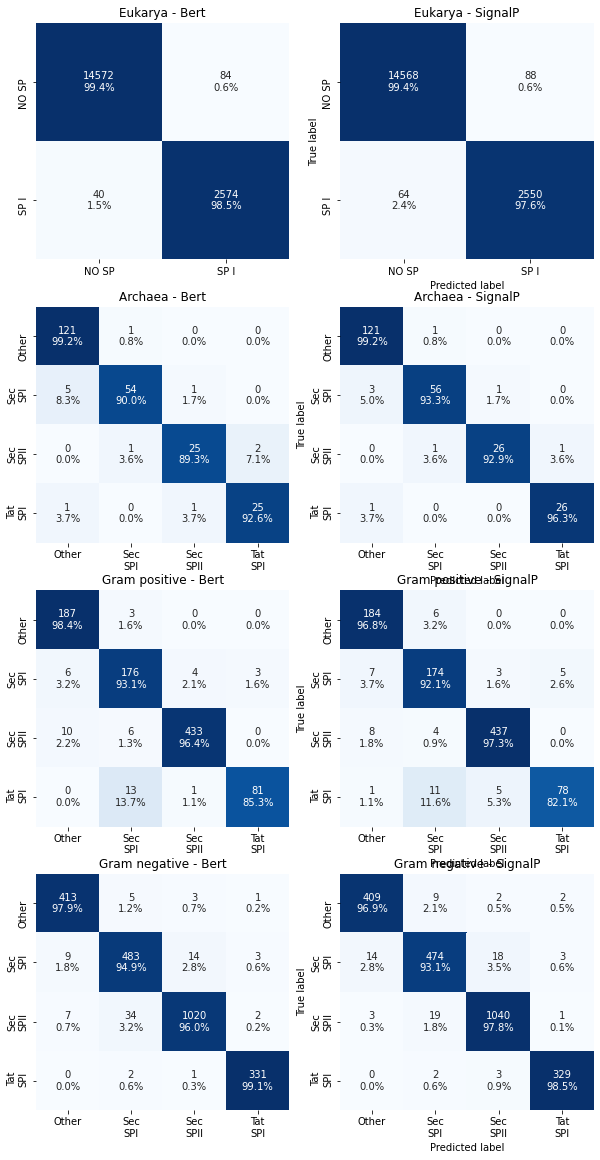

In [15]:
plt.figure(figsize=(10,20))

plt.subplot(4,2,1)
plt.title('Eukarya - Bert')
df_plot = df.loc[df['Kingdom']=='EUKARYA']
#df_plot.loc[df_plot['test_prediction'] !=0, 'test_prediction'] =1 #fix SPII, TAT to SPI
make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True, categories =['NO SP', 'SP I'])

plt.subplot(4,2,2)
plt.title('Eukarya - SignalP')
plot_conf_matrix(signalp_euk_matrix, categories =['NO SP', 'SP I'])

plt.subplot(4,2,3)
plt.title('Archaea - Bert')
df_plot = df.loc[df['Kingdom']=='ARCHAEA']
make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True)

plt.subplot(4,2,4)
plt.title('Archaea - SignalP')
plot_conf_matrix(signalp_arc_matrix)

plt.subplot(4,2,5)
plt.title('Gram positive - Bert')
df_plot = df.loc[df['Kingdom']=='POSITIVE']
make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True)

plt.subplot(4,2,6)
plt.title('Gram positive - SignalP')
plot_conf_matrix(signalp_pos_matrix)

plt.subplot(4,2,7)
plt.title('Gram negative - Bert')
df_plot = df.loc[df['Kingdom']=='NEGATIVE']
make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True)

plt.subplot(4,2,8)
plt.title('Gram negative - SignalP')
plot_conf_matrix(signalp_neg_matrix)

#plt.suptitle('Ensemble predictions (20 models)')
#plt.tight_layout()

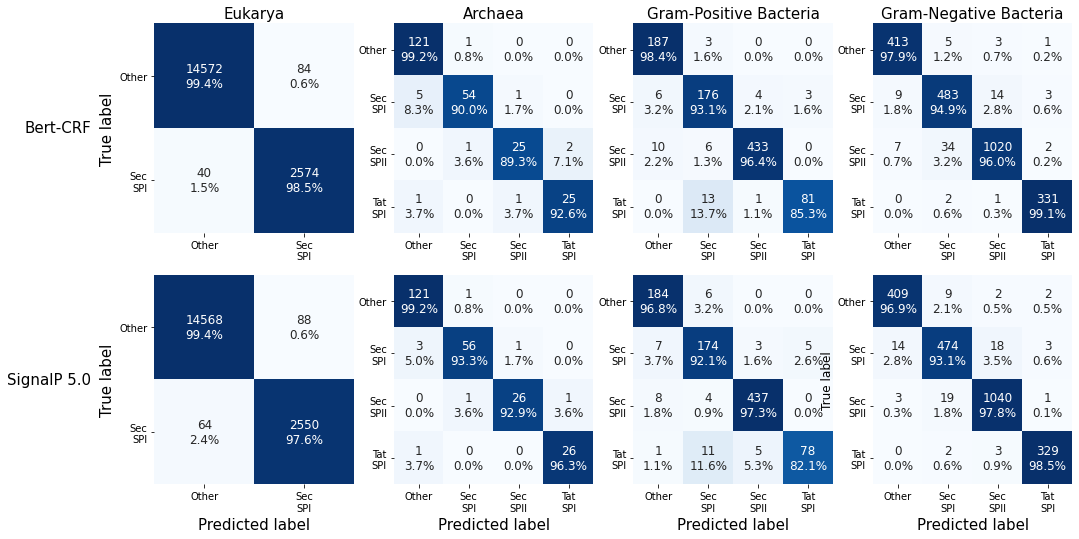

In [116]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy


rows = ['Bert-CRF', 'SignalP 5.0']
cols = ['Eukarya', 'Archaea', 'Gram-Positive Bacteria', 'Gram-Negative Bacteria']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 8))
#plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')

pad = 5 # in points




kwargs = { 
    'label_size':12, 
    'axlabel_size':12, 
    'tick_size':15
    }

ax = axes[0,0]#plt.subplot(4,2,1)
df_plot = df.loc[df['Kingdom']=='EUKARYA']
df_plot.loc[df_plot['test_prediction'] !=0, 'test_prediction'] =1 #fix SPII, TAT to SPI
make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True, categories =['Other', 'Sec\nSPI'], **kwargs, ax=ax)



ax = axes[0,1]
df_plot = df.loc[df['Kingdom']=='ARCHAEA']
make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True, **kwargs, ax=ax)


ax = axes[0,2]
df_plot = df.loc[df['Kingdom']=='POSITIVE']
make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True, **kwargs, ax=ax)


ax = axes[0,3]
df_plot = df.loc[df['Kingdom']=='NEGATIVE']
make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True, **kwargs, ax=ax)

ax = axes[1,0]
plot_conf_matrix(signalp_euk_matrix, categories =['Other', 'Sec\nSPI'], **kwargs, ax=ax)

ax = axes[1,1]
plot_conf_matrix(signalp_arc_matrix, **kwargs, ax=ax)

ax = axes[1,2]
plot_conf_matrix(signalp_pos_matrix, **kwargs, ax=ax)


ax = axes[1,3]
plot_conf_matrix(signalp_neg_matrix, **kwargs, ax=ax)

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=15, ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=15, ha='right', va='center')

#plt.setp(axes.flat, xlabel='Predicted label', ylabel='True label')
for ax in axes[:,0]:
    ax.set_ylabel('True label', size=15)

for ax in axes[1,:]:
    ax.set_xlabel('Predicted label', size=15)

for ax in axes.flat:
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
#fig.subplots_adjust(left=0.15, top=0.95)

plt.subplots_adjust(left=0.15,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2) #default is 0.2

#plt.show()
plt.savefig('plots/confusion_matrices.png')

left = 0.125  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.1  # the bottom of the subplots of the figure
top = 0.9     # the top of the subplots of the figure
wspace = 0.2  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.2  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height

## Probability distributions

In [109]:
#convert integer labels to strings for plotting
df['Predicted label']  =df['test_prediction'].apply(lambda x: ['Other', 'SPI', 'SPII', 'TAT'][x] )

### Correct vs. Wrong predictions - SignalP supplement style

Violin plots + individual preds are easier to interpret than boxplots, and still capture the same information.

/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 90.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 68.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 36.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 59.3% of the points cannot be placed; you may want to decrease the size of the markers or use strip

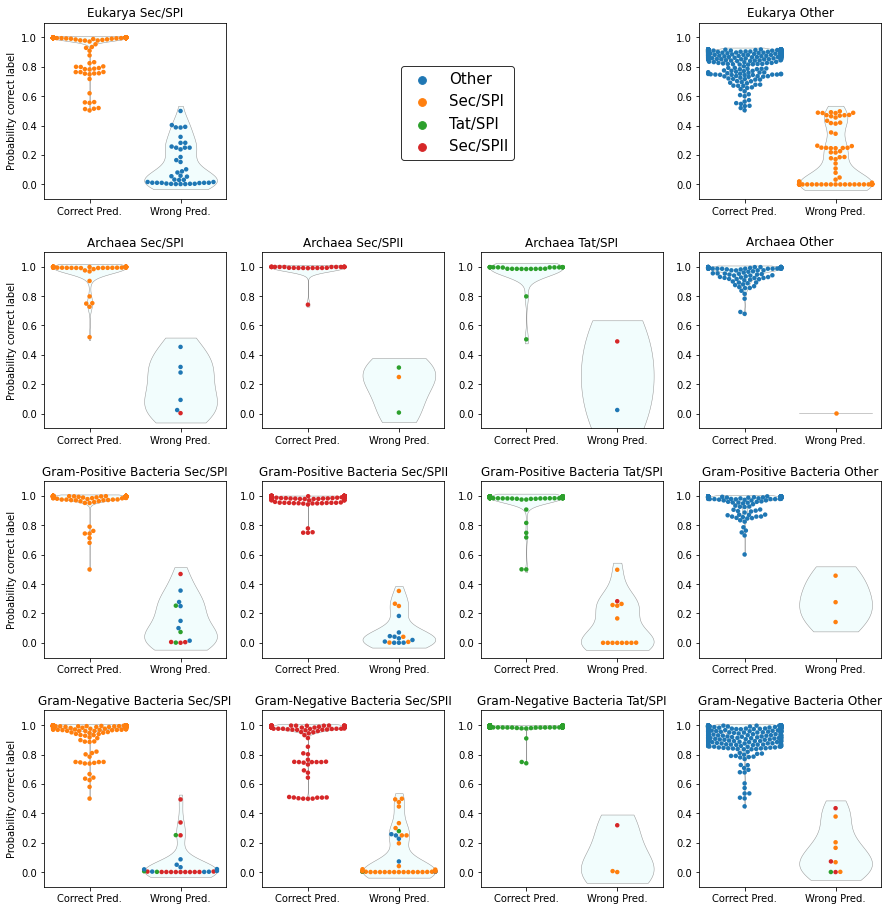

In [117]:
#replace stripplot with swarmplot and boxplot with violinplot as preferred
ordered = ['Other', 'SPI', 'TAT', 'SPII'] #to force color order the same in each plot
#plot all categories
plt.figure(figsize = (15,15))
types = ['SP', 'LIPO', 'TAT', 'NO_SP']
kingdoms = ['EUKARYA', 'ARCHAEA','POSITIVE', 'NEGATIVE']
#kingdoms =['ARCHAEA', 'POSITIVE']
column_names = ['test_p_SPI', 'test_p_SPII', 'test_p_TAT', 'test_p_NO']

plotname_dict = {'SP': 'Sec/SPI', 'LIPO':'Sec/SPII', 'TAT':'Tat/SPI', 'NO_SP': 'Other', 'Other':'Other'}
kingdom_dict = {'EUKARYA': 'Eukarya', 'ARCHAEA':'Archaea','POSITIVE': 'Gram-Positive Bacteria', 'NEGATIVE': 'Gram-Negative Bacteria'}

i = 1
for kingdom in tqdm(kingdoms):
    for typ, colname in zip(types, column_names):
        df_plot = df.loc[(df['Type'] ==typ) & (df['Kingdom']==kingdom)].copy()
        if len(df_plot) >0:
            plt.subplot(4,4,i)
            df_plot['predicted_correctly'] = (df_plot['test_prediction'] == df_plot['target']).copy()
            df_plot['predicted_correctly'] = df_plot['predicted_correctly'].apply(lambda x: 'Correct Pred.' if x else 'Wrong Pred.')
            #sort df to ensure same order in every plot
            df_plot = df_plot.sort_values('predicted_correctly')
            
            
            
            
            #need to subsample eukarya no_sp to make plottable.
            if len(df_plot)>500: #2000
                df_plot = df_plot.sort_values(['predicted_correctly', colname], ascending=[True,False])
                df_plot = df_plot.tail(500)
                
            #TODO don't fit a distribution to low sample sizes.
            sns.violinplot(x="predicted_correctly", y=colname, data=df_plot, linewidth=0.5, color='azure',inner=None, scale='width', cut=0.5)

            sns.swarmplot(x="predicted_correctly", y=colname, data=df_plot, linewidth=0, hue ='Predicted label', hue_order=ordered, size=4.5) #hue= can give true identity of individuals

            plt.ylim(-0.1,1.1)
            plt.title(f'{kingdom_dict[kingdom]} {plotname_dict[typ]}')
            plt.xlabel('')
            plt.ylabel('Probability correct label' if i in [1,5,9,13] else '')
            plt.legend('',frameon=False)

            if i==1:
                ax = plt.gca()
                handles, labels = ax.get_legend_handles_labels()
                plt.legend(handles, ['Other', 'Sec/SPI','Tat/SPI', 'Sec/SPII'], bbox_to_anchor=(1.92, 0.8), loc=2, borderaxespad=0.5, prop={'size': 15},
                          edgecolor='black')
        i+=1        
        

#plt.tight_layout()
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3) #default is 0.2

plt.savefig('plots/crossval_prob_distributions.png')


### Investigate discrepancies

In [81]:
#cols = [x for x in df.columns if 'CS' in x]
#df.loc[df['test_prediction'] != 0][cols]
test, val = 0,1

for test in [0,1,2,3,4]:
    for val in [0,1,2,3,4]:
        if not test == val:
            cols = [f'CS model T{test}V{val}', f'p_NO model T{test}V{val}', f'p_SPI model T{test}V{val}', f'p_SPII model T{test}V{val}' , f'p_TAT model T{test}V{val}']
            preds = df[cols[1:]].idxmax(axis=1)
            preds = preds.str.rstrip(f'T{test}V{val}')
            preds = preds.str.rstrip('model ').apply(lambda x: labelidx[x])

            discrepancy = df.loc[preds != 0][cols[0]] ==  -1
            if discrepancy.sum()>0:
                print(f'Test {test}, Val {val}: {discrepancy.sum()} SP sequences without CS. {list(discrepancy.loc[discrepancy==True].index)}')


Test 0, Val 2: 2 SP sequences without CS. [6205, 16889]
Test 0, Val 3: 2 SP sequences without CS. [359, 15231]
Test 1, Val 3: 2 SP sequences without CS. [16375, 17204]
Test 2, Val 4: 1 SP sequences without CS. [17204]
Test 3, Val 0: 4 SP sequences without CS. [10333, 16456, 16462, 17012]
Test 3, Val 1: 1 SP sequences without CS. [17204]
Test 3, Val 4: 1 SP sequences without CS. [17204]
Test 4, Val 0: 1 SP sequences without CS. [1396]
Test 4, Val 1: 1 SP sequences without CS. [17204]


In [128]:
t = 4
v = 1
index = 17204
record_with_discrepancy = df.iloc[index][[x for x in df.columns if f'T{t}V{v}' in x] + ['test_prediction', 'target', 'Partition'] + [x for x in df.columns if 'CS' in x] ]
print(record_with_discrepancy[f'tags model T{t}V{v}'])
record_with_discrepancy

#6205: inner average fixes it(false positive)
#16889: inner average fixes it.(false positive)
#359: inner average fixes it.(false positive)
#15231: some get it right (exclude -1 preds from CS calling, then should be fine)
#16375: inner average fixes it. (false positive)
#17204: WRONG
#17204: WRONG
#10333: inner average fixes it. (false positive)
#16456:  inner average fixes it. (false positive)
#16462:  inner average fixes it. (false positive)
#17012: inner average fixes it. (false positive)
#17204: WRONG
#17204: WRONG
#1396: false positive. ecluding -1 from calling fixes discrepancy.
#17204: WRONG
#df.iloc[1396][[x for x in df.columns if 'T' not in x]]

OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO


loss model T4V1                                                6.74336
CS model T4V1                                                       -1
p_NO model T4V1                                             0.00453597
p_SPI model T4V1                                              0.995387
p_SPII model T4V1                                                    0
p_TAT model T4V1                                                     0
tags model T4V1      OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
test_prediction                                                      1
target                                                               0
Partition                                                            3
CS model T0V1                                                       -1
CS target                                                           -1
CS model T0V2                                                       -1
CS model T0V3                                                       -1
CS mod

In [129]:
print(df.iloc[17204][[x for x in df.columns if 'T' not in x]].to_string())

Unnamed: 0                           17204
target                                   0
CS target                               -1
identifiers        >Q9SM57|EUKARYA|NO_SP|3
ID                                  Q9SM57
Kingdom                            EUKARYA
Partition                                3
test_prediction                          1
test_loss                          3.59843
test_p_NO                         0.433566
test_p_SPI                        0.566405
test_p_SPII                              0
test_CS                                 -1


__Deprecated old stuff__

In [441]:
df['Predicted label'].unique()

array(['Other', 'SPI', 'TAT', 'SPII'], dtype=object)

In [ ]:
ordered = ['Other', 'SPI', 'TAT', 'SPII'] #to force color order the same in each plot
plt.figure(figsize=(16,10))
for i, kingdom in enumerate(kingdoms):
    plt.subplot(2,2,i+1)
    plt.title(kingdom)
    df_plot = df.loc[(df['Kingdom']==kingdom)].copy()
    
    sns.violinplot(x="Type", y='p(Correct label)', data=df_plot, linewidth=0.5, color='azure',inner=None, scale='width')
    sns.swarmplot(x="Type", y='p(Correct label)', data=df_plot, linewidth=0, hue ='Predicted label', hue_order=ordered,dodge=True)
    if i>0:
        plt.legend('',frameon=False)

In [100]:
kingdom = 'POSITIVE'
typ = 'TAT'
df_cs = df.loc[(df['Kingdom']==kingdom) & (df['Type'] ==typ)][['CS target', 'test_CS']]

#df_cs['CS target'] - df_cs['test_CS']

In [101]:
((df_cs['CS target'] - df_cs['test_CS']) <1).sum()/len(df_cs)

0.7684210526315789

In [107]:
def findMaxProfit(numOfPredictedDay, predictedSharePrices):

    max_difference = -1
    #iterate over days
    for day_buy, value_buy in enumerate(predictedSharePrices):
        for day_sell, value_sell in enumerate(predictedSharePrices[day_buy:]):
            
            max_difference = max( max_difference, value_sell-value_buy)


    return max_difference

In [110]:
findMaxProfit(8,  [5,1,6,3,2,5,6,1,3,6,2,5,5,10])

9

In [123]:
testarray = np.array([5,1,6,3,2,5,6,1,3,6,2,5,5,10])
possible_trade_matrix = testarray -testarray[:,None] #rows = buy_days cols = sell_days
possible_trade_matrix[np.tril_indices_from(possible_trade_matrix)] = -1 #trades into the past are not possible

In [124]:
possible_trade_matrix

array([[-1, -4,  1, -2, -3,  0,  1, -4, -2,  1, -3,  0,  0,  5],
       [-1, -1,  5,  2,  1,  4,  5,  0,  2,  5,  1,  4,  4,  9],
       [-1, -1, -1, -3, -4, -1,  0, -5, -3,  0, -4, -1, -1,  4],
       [-1, -1, -1, -1, -1,  2,  3, -2,  0,  3, -1,  2,  2,  7],
       [-1, -1, -1, -1, -1,  3,  4, -1,  1,  4,  0,  3,  3,  8],
       [-1, -1, -1, -1, -1, -1,  1, -4, -2,  1, -3,  0,  0,  5],
       [-1, -1, -1, -1, -1, -1, -1, -5, -3,  0, -4, -1, -1,  4],
       [-1, -1, -1, -1, -1, -1, -1, -1,  2,  5,  1,  4,  4,  9],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1,  2,  2,  7],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -4, -1, -1,  4],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3,  3,  8],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  5],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  5],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [ ]:
#buy at day 
prices = testarray
days = len(testarray)
for day in range(days):
    day_price =  prices[day]
    

In [ ]:
#got infinite trades

for sellday, sellprice in enumerate(prices[1:]):
    #start a trade
    running_max_profit = 0
    
    #look back in time to find best
    for buyday, buyprice in enumerate(prices[:sellday]):
        running_max_profit = max(running_max_profit, sellprice - buyprice + profit_previous_trade )
        
    
    

In [ ]:
def maxProfit(prices, n, k): 
    #all profits = 0
    profit = [[0 for i in range(k + 1)] 
                 for j in range(n)] 
      
    # Profit is zero for the first 
    # day and for zero transactions 
    for i in range(1, n): 
          
        for j in range(1, k + 1): 
            max_so_far = 0
              
            for l in range(i): 
                max_so_far = max(max_so_far, prices[i] -
                            prices[l] + profit[l][j - 1]) 
                              
            profit[i][j] = max(profit[i - 1][j], max_so_far) 
      
    return profit[n - 1][k] 

In [125]:
# Function to find out maximum profit  
# by buying & selling/ a share atmost  
# k times given stock price of n days  
def maxProfit(price, n, k):  
  
    # Table to store results of subproblems  
    # profit[t][i] stores maximum profit  
    # using atmost t transactions up to  
    # day i (including day i)  
    profit = [[0 for i in range(n + 1)]  
                 for j in range(k + 1)]  
  
    # Fill the table in bottom-up fashion  
    for i in range(1, k + 1):  
        prevDiff = float('-inf') 
        for j in range(1, n):  
            prevDiff = max(prevDiff, 
                           profit[i - 1][j - 1] - 
                           price[j - 1])  
            profit[i][j] = max(profit[i][j - 1],  
                               price[j] + prevDiff)  
  
    return profit

In [129]:
np.array(maxProfit(testarray,14,5))

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  9,  0],
       [ 0,  0,  5,  5,  5,  8,  9,  9,  9, 10, 10, 10, 10, 14,  0],
       [ 0,  0,  5,  5,  5,  8,  9,  9, 11, 14, 14, 14, 14, 18,  0],
       [ 0,  0,  5,  5,  5,  8,  9,  9, 11, 14, 14, 17, 17, 22,  0],
       [ 0,  0,  5,  5,  5,  8,  9,  9, 11, 14, 14, 17, 17, 22,  0]])

have: differences buy_days and sell_days
Greedy decode from buy_day one. 

In [ ]:
for buy_day in range(days):
    for sell_day in range(days[buy_day:]):
        difference = trade_matrix[buy_day, sell_day]

In [ ]:

# Python program to maximize the profit 
# by doing at most k transactions 
# given stock prices for n days 
# Function to find out maximum profit by 
# buying & selling a share atmost k times  
# given stock price of n days 
def maxProfit(prices, n, k): 
    # Bottom-up DP approach 
    profit = [[0 for i in range(k + 1)] 
                 for j in range(n)] 
      
    # Profit is zero for the first 
    # day and for zero transactions 
    for i in range(1, n): 
          
        for j in range(1, k + 1): 
            max_so_far = 0
              
            for l in range(i): 
                max_so_far = max(max_so_far, prices[i] -
                            prices[l] + profit[l][j - 1]) 
                              
            profit[i][j] = max(profit[i - 1][j], max_so_far) 
      
    return profit[n - 1][k] 
  
# Driver code 
k = 2
prices = [10, 22, 5, 75, 65, 80] 
n = len(prices) 
  
print("Maximum profit is:", 
       maxProfit(prices, n, k)) 
  
# This code is contributed by vaibhav29498 

In [130]:
import torch

In [145]:
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling

In [150]:
tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert', do_lower_case=False)

In [151]:
tokenizer._mask_token

'[MASK]'